# Wuhan Corona Virus Outbreak

- webscraped infected counts from national health commision via wikipedia
- infection counts are fitted to a simple exponential distribution 


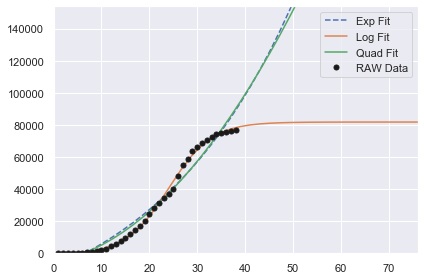

38990.61727871507 0.033182021186482225 -48493.63313931117
82509.96289601711 24.042101570569145 0.22387722244293268 -713.0470777297888
52.24319309198906 -524.8603649207228 -5379.495258428052


In [254]:
import requests
import lxml.html as lh
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from bs4 import BeautifulSoup

%matplotlib inline

url = 'https://en.wikipedia.org/wiki/2019%E2%80%9320_Wuhan_coronavirus_outbreak'
page = requests.get(url).text
soup = BeautifulSoup(page,'lxml')
#print(soup.prettify())
My_table = soup.find('div',{'class':'barbox tright'})

datesfinal = []
countsfinal = []
count1end = 0

#dates = My_table.findAll('td', style='padding-right:0.4em; padding-left:0.4em; width:auto')
dates = My_table.findAll('span', {'class' : 'nowrap'})

for date in dates[1:]:
    datesfinal.append((pd.to_datetime(date.get_text())))
    
#counts = My_table.findAll('td', colspan = '2', style='padding-left:0.4em; text-align:left; width:auto;')
counts = My_table.findAll('td', style='padding:0px 2px 0px 4px;text-align:right;width:38px')
counts2 = My_table.findAll('td', style='padding:0px 2px 0px 6px;text-align:right;width:38px')

'''
#Old Methods (changed because Wikipedia updates)
for count in counts:
    countsfinal.append(int(count.get_text()[0:count.get_text().find('(')].replace(',',''))) 


for count in counts:
    if count.get_text().find('/') == -1:
        countsfinal.append(int(count.get_text()[0:count.get_text().find('(')].replace(',',''))) 
    else: 
        countsfinal.append(int(count.get_text()[count.get_text().find('/')+1:count.get_text().find('(')].replace(',',''))) 

#Old Method 2
for count in counts[1:]:
        countsfinal.append(int(count.get_text().rstrip().lstrip()[0:count.get_text().rstrip().lstrip().find('\n')].replace(',','')))
      
'''
        

for i,count in enumerate(counts2):
    if len(count.get_text()) > 1 and count1end == 0:
        count1end = i


for i,count in enumerate(counts):
    if i < count1end:
        countsfinal.append(int(count.get_text().rstrip().lstrip().replace(',','')))

for i,count in enumerate(counts2):
    if i >= count1end:
        countsfinal.append(int(count.get_text().rstrip().lstrip().replace(',','')))
        
        
d=list(zip(datesfinal, countsfinal))
df=pd.DataFrame(data=d, columns=['Date','Infected'])    

def exponential_fit(x, a, b, c):
    return a*np.exp(b*x) + c

#sigmoid is special case of logistic function whereas:
# L = 1, k = 1, X0 = 0
# ref: https://stats.stackexchange.com/questions/204484/what-are-the-differences-between-logistic-function-and-sigmoid-function
'''
def sigmoidal_fit(x, k, x0):
    return (1 / (1 + np.exp(-k*(x-x0))))
'''

def logistic_fit(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def quadratic_fit(x, a, b, c):
    y = a*(x**2) - (b*x) + c
    return (y)

def tanh_fit(x, eta=1, phi=1):
    y = np.tanh(eta * (x + phi))
    return (y)

x = np.linspace(1,len(df),len(df))
y = np.array(df['Infected'])

# Exponential Fit
fitting_parameters_exp, covariance_exp = curve_fit(exponential_fit, x, y)
a, b, c = fitting_parameters_exp
'''
# Sigmoidal Fit
fitting_parameters_sig, covariance_sig = curve_fit(sigmoidal_fit, x, y, method='dogbox')
a1, b1 = fitting_parameters_sig
'''
# Logistic Fit
p0 = [max(y), np.median(x),1,min(y)] # this is an mandatory initial guess
fitting_parameters_log, covariance_log = curve_fit(logistic_fit, x, y,p0, method='dogbox')
a2, b2, c2, d2 = fitting_parameters_log

# Quadratic Fit
fitting_parameters_quad, covariance_quad = curve_fit(quadratic_fit, x, y)
a3, b3, c3 = fitting_parameters_quad

# Tanh Fit (WIP)
#fitting_parameters_tanh, covariance_tanh = curve_fit(tanh_fit, x, y)
#a4, b4 = fitting_parameters_tanh

x_min = 0 
x_max = len(df)*2
x_fit = np.linspace(x_min, x_max, len(df)) 

plt.plot(x_fit, exponential_fit(x_fit, *fitting_parameters_exp), '--', label='Exp Fit')
# plt.plot(x_fit, sigmoidal_fit(x_fit, *fitting_parameters_sig), '-', label='Sig Fit')
plt.plot(x_fit, logistic_fit(x_fit, *fitting_parameters_log), '-', label='Log Fit')
plt.plot(x_fit, quadratic_fit(x_fit, *fitting_parameters_quad), '-', label='Quad Fit')
#plt.plot(x_fit, tanh_fit(x_fit, *fitting_parameters_tanh), '-', label='Tanh Fit')


plt.plot(x, y, '.', label='RAW Data', color='k', markersize=10)

plt.plot(title='Wuhan')
plt.ylim(0, max(df['Infected'])*2)
plt.xlim(0,len(df)*2)
plt.tight_layout()
plt.legend()

plt.show()

print(a,b,c)
#print(a1,b1)
print(a2,b2,c2,d2)
print(a3,b3,c3)


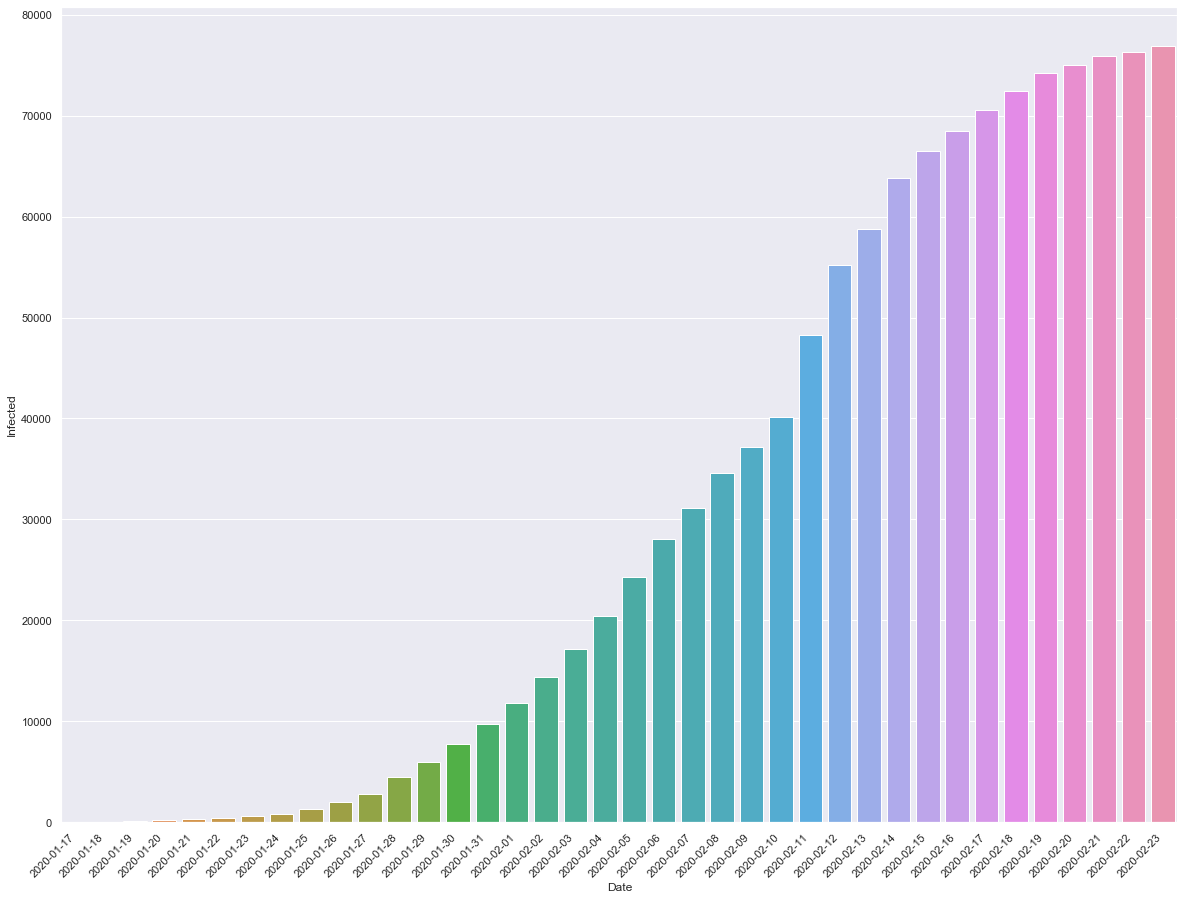

In [262]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set(rc={'figure.figsize':(20,15)})

g = sns.barplot(data=df,x=df['Date'], y='Infected')

x_dates = df['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
g.set_xticklabels(labels=x_dates, rotation=45, ha='right');

In [252]:
print(curve_fit(exponential_fit, x, y))
print(curve_fit(logistic_fit, x, y))
print(curve_fit(quadratic_fit, x, y))



(array([ 3.89906173e+04,  3.31820212e-02, -4.84936331e+04]), array([[ 2.10883004e+08, -1.01683895e+02, -2.40875458e+08],
       [-1.01683895e+02,  4.94226158e-05,  1.15415870e+02],
       [-2.40875458e+08,  1.15415870e+02,  2.77388560e+08]]))
(array([ 8.25099267e+04,  2.40420974e+01,  2.23877435e-01, -7.13040685e+02]), array([[ 2.01107931e+06,  1.36060835e+02, -1.01394214e+01,
        -5.46801545e+05],
       [ 1.36060835e+02,  3.06834244e-02, -6.22476820e-04,
         7.99803783e+00],
       [-1.01394214e+01, -6.22476820e-04,  6.66366216e-05,
         2.97537000e+00],
       [-5.46801545e+05,  7.99803783e+00,  2.97537000e+00,
         2.92989314e+05]]))
(array([   52.24319309,  -524.86036492, -5379.49525843]), array([[6.35790819e+01, 2.47958422e+03, 1.65305614e+04],
       [2.47958422e+03, 1.02807377e+05, 7.63711935e+05],
       [1.65305614e+04, 7.63711935e+05, 7.35279350e+06]]))
